In [345]:
import requests
import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [346]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import numpy as np
from riotwatcher import LolWatcher, ApiError
import datetime

# golbal variables
api_key = 'RGAPI-3036131f-db68-473c-af19-082e05601aad'
watcher = LolWatcher(api_key)

In [347]:
def is_today(time):
    time /= 1000
    evaluate = datetime.datetime.utcfromtimestamp(time).strftime('%Y-%m-%d')
    today = datetime.datetime.today().strftime('%Y-%m-%d')
    return evaluate == today

In [348]:
def same_day(time_1, time_2):
    time_1 /= 1000
    time_2 /= 1000
    
    evaluate_1 = datetime.datetime.utcfromtimestamp(time_1).strftime('%Y-%m-%d')
    evaluate_2 = datetime.datetime.utcfromtimestamp(time_2).strftime('%Y-%m-%d')
    
    return evaluate_1 == evaluate_2

In [356]:
def pipeline_data(pid, accountid):
    '''
    Given player idea, generate a single row of data
    '''
    region = 'na1'
    mapping_list = [] # stores all mappings
    
    
    #try:
    solo_queue_rank_info = [x for x in watcher.league.by_summoner(region, pid) if x['queueType'] == 'RANKED_SOLO_5x5'][0]  # query 1

    # compute match features #
    matches = watcher.match.matchlist_by_account(region, accountid)
    eval_day = None
    idx = 0
    print(matches['matches'])
    print(solo_queue_rank_info)

    for game in matches['matches']:
        print ('idx = ', idx)
        mapping = {}
        if idx == 0:
            # gen label #
            eval_day = game['timestamp']
            game_id = game['gameId']
            match_detail = watcher.match.by_id(region, game_id)
            game_length_sec=match_detail['gameDuration']
            participant_id = [x for x in match_detail['participantIdentities'] if x['player']['accountId'] == accountid][0]['participantId']
            match_features = [x for x in match_detail['participants'] if x['participantId'] == participant_id][0]
            label = match_features['stats']['win']

            idx+=1
        elif idx < 6:
            if same_day(game['timestamp'], eval_day):
                # same day, record this data
                game_id = game['gameId']
                match_detail = watcher.match.by_id(region, game_id)
                participant_id = [x for x in match_detail['participantIdentities'] if x['player']['accountId'] == accountid][0]['participantId']
                match_features = [x for x in match_detail['participants'] if x['participantId'] == participant_id][0]

                win = match_features['stats']['win']

                mapping['win'] = match_features['stats']['win']
                mapping['kills'] = match_features['stats']['kills']
                mapping['deaths'] = match_features['stats']['deaths']
                mapping['assists'] = match_features['stats']['assists']
                mapping['kda'] = match_features['stats']['kills'] + match_features['stats']['assists'] / match_features['stats']['deaths']
                mapping['totalDamageDealtToChampions'] = match_features['stats']['totalDamageDealtToChampions']
                mapping['magicDamageDealtToChampions'] = match_features['stats']['magicDamageDealtToChampions']
                mapping['physicalDamageDealtToChampions'] = match_features['stats']['physicalDamageDealtToChampions']

                mapping['TotalDamageDealtToChampionsPerMinute'] = match_features['stats']['totalDamageDealtToChampions']/game_length_sec*60
                mapping['MagicDamageDealtToChampionsPerMinute'] = match_features['stats']['magicDamageDealtToChampions']/game_length_sec*60
                mapping['PhysicalDamageDealtToChampionsPerMinute'] = match_features['stats']['physicalDamageDealtToChampions']/game_length_sec*60

                mapping['visionScore'] = match_features['stats']['visionScore']

                mapping['goldEarned'] = match_features['stats']['goldEarned']
                mapping['goldEarnedPerMinute'] = match_features['stats']['goldEarned']/game_length_sec*60

                mapping['totalMinionsKilled'] = match_features['stats']['totalMinionsKilled']
                mapping['totalMinionsKilledPerMinute'] = match_features['stats']['totalMinionsKilled']/game_length_sec*60

                mapping['role'] = match_features['timeline']['role']
                mapping['lane'] = match_features['timeline']['lane']

                mapping_list.append(mapping)

                idx+=1
            elif idx == 1:
                # if we are looking at the second game, and it is not in the same day, we have no good data. Do not record anything
                # reset and start over
                eval_day = game['timestamp']
                idx = 0
            else:
                # no data past g-2, replace with -1
                if idx < 5:
                    mapping['win'] = -1
                    mapping['kills'] = -1
                    mapping['deaths'] = -1
                    mapping['assists'] = -1
                    mapping['kda'] = -1
                    mapping['totalDamageDealtToChampions'] = -1
                    mapping['magicDamageDealtToChampions'] = -1
                    mapping['physicalDamageDealtToChampions'] = -1

                    mapping['TotalDamageDealtToChampionsPerMinute'] = -1
                    mapping['MagicDamageDealtToChampionsPerMinute'] = -1
                    mapping['PhysicalDamageDealtToChampionsPerMinute'] = -1

                    mapping['visionScore'] = -1

                    mapping['goldEarned'] = -1
                    mapping['goldEarnedPerMinute'] = -1

                    mapping['totalMinionsKilled'] = -1
                    mapping['totalMinionsKilledPerMinute'] = -1

                    mapping['role'] = -1
                    mapping['lane'] = -1
                idx+=1
                mapping_list.append(mapping)
        else:
            # we only care about past 5 games. If we reach here, reset
            break

    return mapping_list

#     except Exception as e: 
#         print(e)
#         print("no solo queue info")
#         return None


In [357]:
# players = ['wellesly', 'riot wizphil', 'gween tea', 'GnarMains2Gulag']
region = 'na1'
players = ['talon abuser']
master_list = []
for player in players:
    print ('on player = ', player)
    player = watcher.summoner.by_name(region, player)

    mapping_list = pipeline_data(player['id'], player['accountId'])
    master_list.extend(mapping_list)

on player =  talon abuser
[{'platformId': 'NA1', 'gameId': 3652450907, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604792717876, 'role': 'SOLO', 'lane': 'MID'}, {'platformId': 'NA1', 'gameId': 3652405997, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604791388289, 'role': 'DUO_SUPPORT', 'lane': 'NONE'}, {'platformId': 'NA1', 'gameId': 3652382442, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604789365107, 'role': 'SOLO', 'lane': 'MID'}, {'platformId': 'NA1', 'gameId': 3652289294, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604787482252, 'role': 'SOLO', 'lane': 'MID'}, {'platformId': 'NA1', 'gameId': 3652272348, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604784478901, 'role': 'SOLO', 'lane': 'MID'}, {'platformId': 'NA1', 'gameId': 3652256698, 'champion': 91, 'queue': 420, 'season': 13, 'timestamp': 1604782724437, 'role': 'DUO', 'lane': 'TOP'}, {'platformId': 'NA1', 'gameId': 3649354175, 'champion': 91, 'queue': 420, 'sea

idx =  1
idx =  2
idx =  3
idx =  4
idx =  5
idx =  6


In [358]:
# Convert to DF
df=pd.DataFrame(master_list)

# Fix Support & ADC Labels
df.loc[df.role == 'DUO_SUPPORT', 'lane'] = "SUPPORT"
df.loc[df.role == 'DUO_CARRY', 'lane'] = "ADC"

# Create Column Games_Ago for X Axis Ordering
df['games_ago'] = df.reset_index().index+1
df

,win,kills,deaths,assists,kda,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,TotalDamageDealtToChampionsPerMinute,MagicDamageDealtToChampionsPerMinute,PhysicalDamageDealtToChampionsPerMinute,visionScore,goldEarned,goldEarnedPerMinute,totalMinionsKilled,totalMinionsKilledPerMinute,role,lane,games_ago
0,True,12,1,7,19.000000,10625,0,10447,456.661891,0.000000,449.011461,9,9186,394.813754,92,3.954155,DUO_SUPPORT,SUPPORT,1
1,True,8,10,7,8.700000,17255,0,16065,741.618911,0.000000,690.472779,22,10457,449.441261,155,6.661891,SOLO,MIDDLE,2
2,True,19,4,6,20.500000,24602,0,23706,1057.392550,0.000000,1018.882521,15,15063,647.406877,144,6.189112,SOLO,MIDDLE,3
3,True,20,10,9,20.900000,37798,0,35562,1624.555874,0.000000,1528.452722,18,19285,828.868195,189,8.123209,SOLO,MIDDLE,4
4,True,6,6,10,7.666667,12841,11,12073,551.905444,0.472779,518.896848,10,8607,369.928367,105,4.512894,DUO,TOP,5


In [409]:
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_point, geom_line, geom_smooth, scale_x_reverse, geom_text, facet_wrap, xlab, ylab, ylim, ggtitle

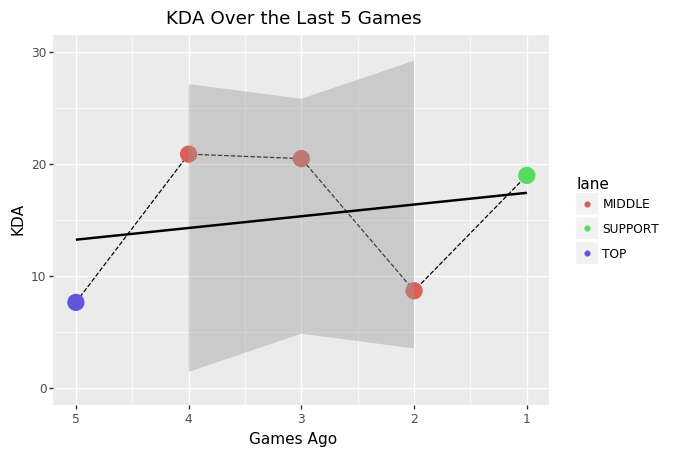

<ggplot: (-9223371910734750264)>

In [410]:
# KDA
ggplot(df) + aes(x='games_ago', y='kda') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + ylim(0,30) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('KDA') + ggtitle("KDA Over the Last 5 Games")

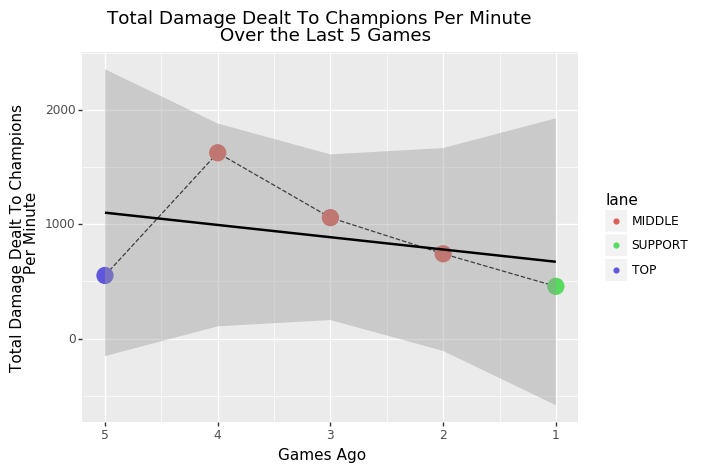

<ggplot: (-9223371910740605636)>

In [416]:
# TotalDamageDealtToChampionsPerMinute
ggplot(df) + aes(x='games_ago', y='TotalDamageDealtToChampionsPerMinute') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('Total Damage Dealt To Champions \n Per Minute') + ggtitle("Total Damage Dealt To Champions Per Minute \n Over the Last 5 Games")

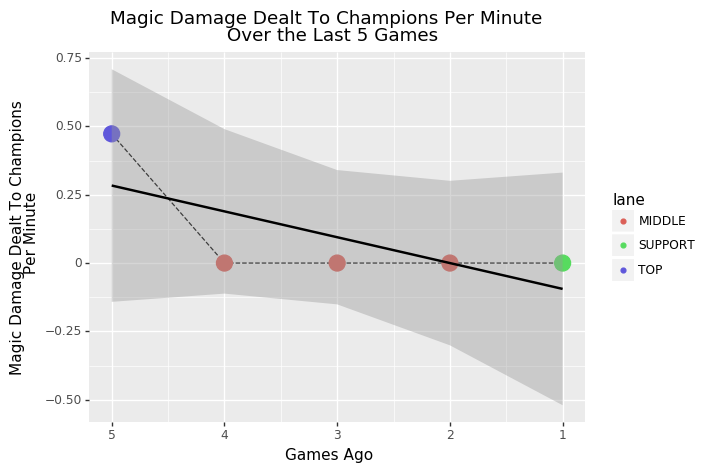

<ggplot: (-9223371910740207721)>

In [423]:
# MagicDamageDealtToChampionsPerMinute
ggplot(df) + aes(x='games_ago', y='MagicDamageDealtToChampionsPerMinute') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('Magic Damage Dealt To Champions \n Per Minute') + ggtitle("Magic Damage Dealt To Champions Per Minute \n Over the Last 5 Games")

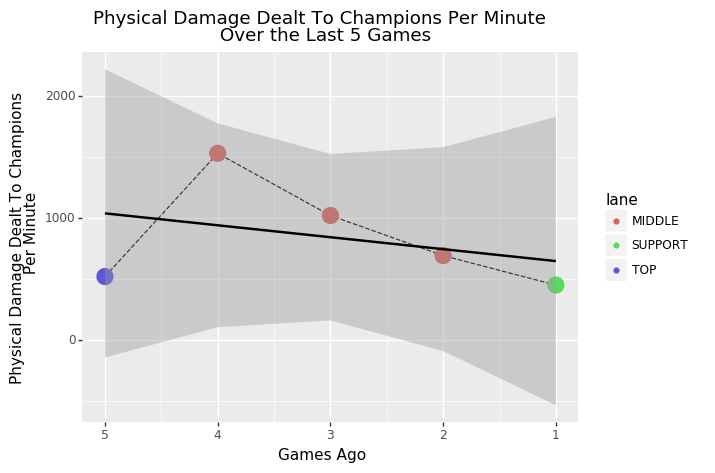

<ggplot: (126119985735)>

In [424]:
# PhysicalDamageDealtToChampionsPerMinute
ggplot(df) + aes(x='games_ago', y='PhysicalDamageDealtToChampionsPerMinute') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('Physical Damage Dealt To Champions \n Per Minute') + ggtitle("Physical Damage Dealt To Champions Per Minute \n Over the Last 5 Games")

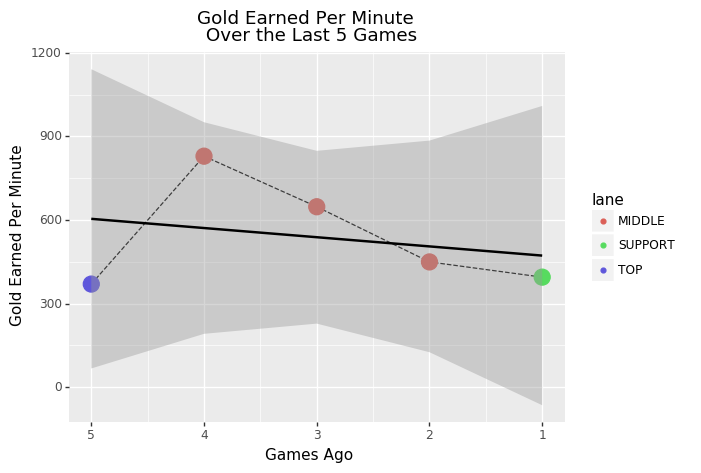

<ggplot: (-9223371910740858543)>

In [425]:
# goldEarnedPerMinute
ggplot(df) + aes(x='games_ago', y='goldEarnedPerMinute') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('Gold Earned Per Minute') + ggtitle("Gold Earned Per Minute \n Over the Last 5 Games")

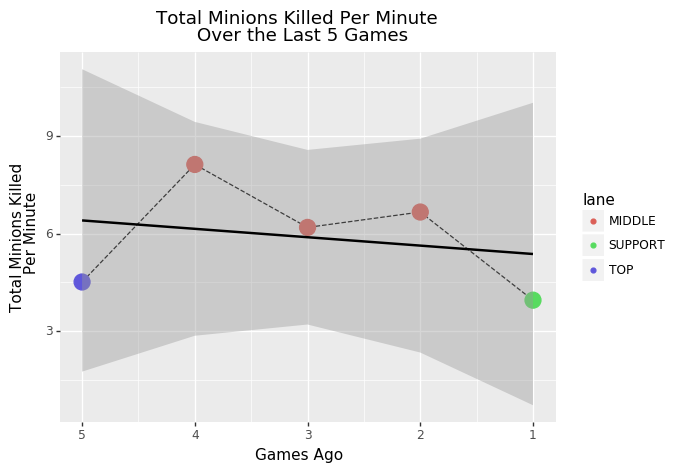

<ggplot: (126115737180)>

In [426]:
# totalMinionsKilledPerMinute
ggplot(df) + aes(x='games_ago', y='totalMinionsKilledPerMinute') + geom_line(color="black", linetype='dashed') + geom_point(aes(color='lane', size=3), show_legend={'size': False}) + scale_x_reverse() + geom_smooth(method = "lm") + xlab('Games Ago') + ylab('Total Minions Killed \n Per Minute') + ggtitle("Total Minions Killed Per Minute \n Over the Last 5 Games")